# Описание проекта

Подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Нам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

# 1. Подготовка данных

### 1.1 Загрузим необходимые библиотеки, датасет и получим общую информацию 

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.preprocessing import StandardScaler

In [2]:
train = pd.read_csv('/datasets/gold_recovery_train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

In [3]:
test = pd.read_csv('/datasets/gold_recovery_test.csv')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

In [4]:
full = pd.read_csv('/datasets/gold_recovery_full.csv')
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

## Выводы:
1. Представлено 3 датасета: обучающий, тестовый и полный.
2. В полном и обучающем наборах данных 87 параметров, в тестовом - 52.
3. Во всех столбцах кроме date имеются пропуски.

### 1.2 Работа с пропусками

Проверим, совпадают ли пропуски в обучающей и тестовой выборке с полным датасетом

In [5]:
col_test = test.columns

In [6]:
col_train = train.columns

In [7]:
for col in col_test:
    sum_nan = train[col].isna().sum() + test[col].isna().sum()
    full_nan = full[col].isna().sum()
    difference = full_nan - sum_nan
print(difference.sum())

0


- Количество пропусков совпадает, следовательно датасеты идентичны по пропускам

Посмотрим доли пропусков во всем датасете

In [8]:
print(full.isna().mean().sort_values(ascending=False))

rougher.output.recovery                     0.137304
rougher.output.tail_ag                      0.120488
rougher.output.tail_sol                     0.120444
rougher.output.tail_au                      0.120444
rougher.input.floatbank11_xanthate          0.099357
                                              ...   
primary_cleaner.state.floatbank8_b_level    0.001893
primary_cleaner.state.floatbank8_c_level    0.001893
primary_cleaner.state.floatbank8_d_level    0.001893
primary_cleaner.input.feed_size             0.000000
date                                        0.000000
Length: 87, dtype: float64


- максимальная доля пропусков не превышает 14%

Предположим, что суммарная концентрация всех веществ одной из стадий обработки должна равняться 100. Проверим:

In [9]:
sum = (
    full['final.output.concentrate_ag']
    + full['final.output.concentrate_pb']
    + full['final.output.concentrate_sol']
    + full['final.output.concentrate_au']
    + full['final.output.tail_ag']
    + full['final.output.tail_pb']
    + full['final.output.tail_sol']
    + full['final.output.tail_au']
)
sum.describe()

count    22034.000000
mean        86.360731
std         28.027858
min          0.000000
25%         90.582012
50%         95.098590
75%         99.077724
max        111.926638
dtype: float64

- Предположение неверно. Заполнить пропуски, исходя из концентрации известных веществ невозможна.

Удалим пропуски в столбцах из тестовой выборки

In [10]:
full.dropna(subset = col_test, inplace = True)
train.dropna(subset = col_test, inplace = True)
test.dropna(subset = col_test, inplace = True)

In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5383 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5383 non-null object
primary_cleaner.input.sulfate                 5383 non-null float64
primary_cleaner.input.depressant              5383 non-null float64
primary_cleaner.input.feed_size               5383 non-null float64
primary_cleaner.input.xanthate                5383 non-null float64
primary_cleaner.state.floatbank8_a_air        5383 non-null float64
primary_cleaner.state.floatbank8_a_level      5383 non-null float64
primary_cleaner.state.floatbank8_b_air        5383 non-null float64
primary_cleaner.state.floatbank8_b_level      5383 non-null float64
primary_cleaner.state.floatbank8_c_air        5383 non-null float64
primary_cleaner.state.floatbank8_c_level      5383 non-null float64
primary_cleaner.state.floatbank8_d_air        5383 non-null float64
primary_cleaner.state.floatbank8_d_level      5383 non-null float64
rougher.in

### 1.3 Проверка целевых признаков

Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака rougher.output.recovery. Найдем MAE между вашими расчётами и значением признака. Опишите выводы

Для проверки сформируем датасет без пропусков в расчетном столбце


In [12]:
train_nan = train
train_nan.dropna(subset = ['rougher.output.recovery'], inplace = True)

In [13]:
train_nan['rougher.output.tail_au'].sort_values()

16788    0.020676
15848    0.024545
16789    0.031234
13093    0.031642
15836    0.050228
           ...   
2591     6.648954
8946     7.325192
2920     8.649598
2590     8.733552
5037     8.783082
Name: rougher.output.tail_au, Length: 12767, dtype: float64

Создадим функцию для расчета эффективности обогащения и посчитаем MAE для рассчитанного значения:

In [14]:
def recovery_rougher(data):
    c = data['rougher.output.concentrate_au']
    f = data['rougher.input.feed_au']
    t = data['rougher.output.tail_au']
    if c > 0 and f > 0 and t > 0:
        rec = ((c * (f - t)) / (f * (c - t))) * 100
        return rec

In [15]:
train_nan['rougher.output.recovery_check'] = train_nan.apply(recovery_rougher, axis=1).fillna(0)

In [16]:
mean_absolute_error(train_nan['rougher.output.recovery'], train_nan['rougher.output.recovery_check'])
    

9.520664632288798e-15

- MAE для расчетного значения rougher.output.recovery получилось примерно = 0, следовательно целевые признаки в датасетах посчитаны верно

### 1.4 Анализ признаков, отсутствующих в тестовой выборке

Проанализируем признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?

In [17]:
not_col = []
for col in col_train:
    if col not in col_test:
        not_col.append(col)

In [18]:
len(not_col)

34

In [19]:
not_col

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

Недоступными признаками в тестовой выборке являются:
1. Целевые признаки - final.output.recovery, rougher.output.recovery
2. Параметры продукта после каждого этапа - содержание веществ в концентрате и хвостах
3. Расчетные характеристики флотации
Тип данных - вещественный

### 1.5 Изменение типов данных

Изменим тип данных в столбце date на datetime

In [20]:
full['date'] = pd.to_datetime(full['date'], format='%Y-%m-%d %H:%M:%S')
train['date'] = pd.to_datetime(train['date'], format='%Y-%m-%d %H:%M:%S')
test['date'] = pd.to_datetime(test['date'], format='%Y-%m-%d %H:%M:%S')

### 1.6 Работа с целевыми признаками

Заполним по возможности пропуски в целевом признаке rougher.output.recovery для полного датасета и для тренировочного расчетными значениями

In [21]:
full['rougher.output.recovery_check'] = full.apply(recovery_rougher, axis=1)

In [22]:
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18905 entries, 0 to 22715
Data columns (total 88 columns):
date                                                  18905 non-null datetime64[ns]
final.output.concentrate_ag                           18899 non-null float64
final.output.concentrate_pb                           18901 non-null float64
final.output.concentrate_sol                          18679 non-null float64
final.output.concentrate_au                           18902 non-null float64
final.output.recovery                                 18664 non-null float64
final.output.tail_ag                                  18903 non-null float64
final.output.tail_pb                                  18887 non-null float64
final.output.tail_sol                                 18867 non-null float64
final.output.tail_au                                  18905 non-null float64
primary_cleaner.input.sulfate                         18905 non-null float64
primary_cleaner.input.depressant     

- В исходном датасете указано максимально возможное количество целевых признаков, поэтому заполнить пропуски не получится 

Выделим целевые признаки в отдельный датасет

In [23]:
full_recovery = full[['date', 'final.output.recovery', 'rougher.output.recovery']]

Для проверки модели на тестовой выборке, добавим к ней целевые признаки из полного датасета

In [24]:
test = test.merge(full_recovery, on='date', how='left')

In [25]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5383 entries, 0 to 5382
Data columns (total 55 columns):
date                                          5383 non-null datetime64[ns]
primary_cleaner.input.sulfate                 5383 non-null float64
primary_cleaner.input.depressant              5383 non-null float64
primary_cleaner.input.feed_size               5383 non-null float64
primary_cleaner.input.xanthate                5383 non-null float64
primary_cleaner.state.floatbank8_a_air        5383 non-null float64
primary_cleaner.state.floatbank8_a_level      5383 non-null float64
primary_cleaner.state.floatbank8_b_air        5383 non-null float64
primary_cleaner.state.floatbank8_b_level      5383 non-null float64
primary_cleaner.state.floatbank8_c_air        5383 non-null float64
primary_cleaner.state.floatbank8_c_level      5383 non-null float64
primary_cleaner.state.floatbank8_d_air        5383 non-null float64
primary_cleaner.state.floatbank8_d_level      5383 non-null float64
ro

Удалим из датасетов пропуски в целевых признаках

In [26]:
full.dropna(subset = ['rougher.output.recovery', 'final.output.recovery'], inplace = True)
train.dropna(subset = ['rougher.output.recovery', 'final.output.recovery'], inplace = True)
test.dropna(subset = ['rougher.output.recovery', 'final.output.recovery'], inplace = True)

# 2. Анализ данных

### 2.1 Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

2.1.1 Концентрация Au

- Покажем распределение концентраций на общем графике

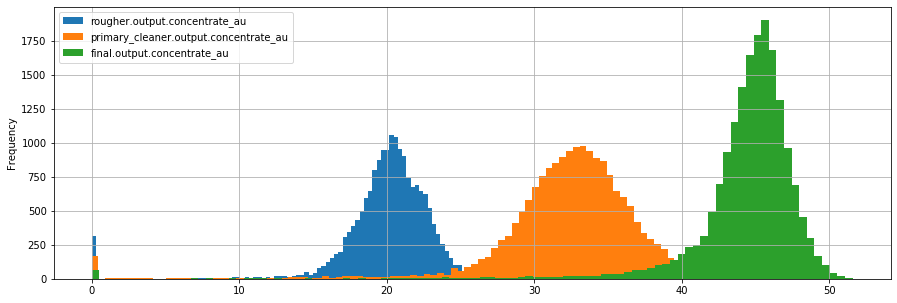

In [27]:
ax = full['rougher.output.concentrate_au'].plot(kind='hist', figsize=(15, 5), bins=100, grid=True, legend=True)
full['primary_cleaner.output.concentrate_au'].plot(kind='hist', figsize=(15, 5), ax=ax, bins=100, grid=True, legend=True)
full['final.output.concentrate_au'].plot(kind='hist', figsize=(15, 5), ax=ax, bins=100, grid=True, legend=True)
plt.show()

- Из графика видно, что концентрация золота увеличивается. Посчитаем на сколько увеличивается концентрация

In [28]:
print((full['primary_cleaner.output.concentrate_au'] - full['rougher.output.concentrate_au']).mean())

12.234057141076471


In [29]:
print((full['final.output.concentrate_au'] - full['primary_cleaner.output.concentrate_au']).mean())

12.03950239195873


После каждого этапа концентрация золота увеличивается в среднем на 12 %.

2.1.2 Концентрация Ag

- Покажем распределение концентраций на общем графике

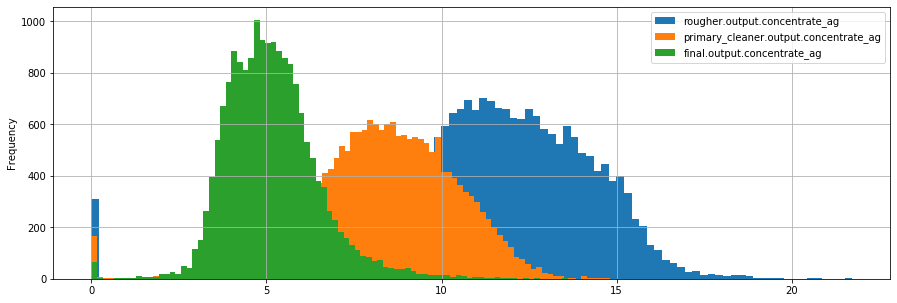

In [30]:
ax = full['rougher.output.concentrate_ag'].plot(kind='hist', figsize=(15, 5), bins=100, grid=True, legend=True)
full['primary_cleaner.output.concentrate_ag'].plot(kind='hist', figsize=(15, 5), ax=ax, bins=100, grid=True, legend=True)
full['final.output.concentrate_ag'].plot(kind='hist', figsize=(15, 5), ax=ax, bins=100, grid=True, legend=True)
plt.show()

- Из графика видно, что концентрация серебра увеличивается. Посчитаем на сколько уменьшается концентрация

In [31]:
print((full['primary_cleaner.output.concentrate_ag'] - full['rougher.output.concentrate_ag']).mean())

-3.518517294102368


In [32]:
print((full['final.output.concentrate_ag'] - full['primary_cleaner.output.concentrate_ag']).mean())

-3.348605492688304


После каждого этапа концентрация серебра уменьшается в среднем на 3 %.

2.1.3 Концентрация Pb

- Покажем распределение концентраций на общем графике

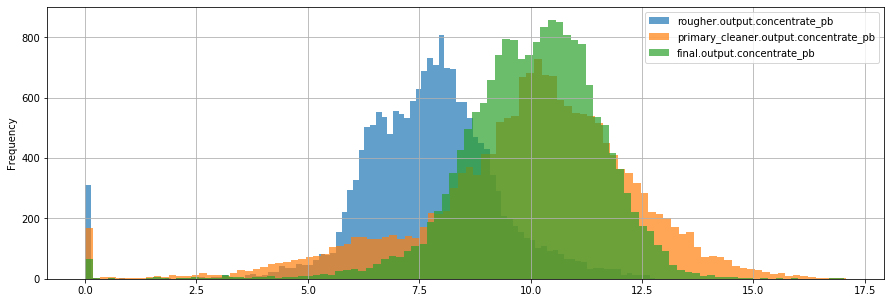

In [33]:
ax = full['rougher.output.concentrate_pb'].plot(kind='hist', figsize=(15, 5), bins=100, grid=True, legend=True, alpha=0.7)
full['primary_cleaner.output.concentrate_pb'].plot(kind='hist', figsize=(15, 5), ax=ax, bins=100, grid=True, legend=True, alpha=0.7)
full['final.output.concentrate_pb'].plot(kind='hist', figsize=(15, 5), ax=ax, bins=100, grid=True, legend=True, alpha=0.7)
plt.show()

- Из графика видно, что концентрация свинца увеличивается после флотации, и не изменяется после очистки. Посчитаем на сколько изменяется концентрация

In [34]:
print((full['primary_cleaner.output.concentrate_pb'] - full['rougher.output.concentrate_pb']).mean())

2.2258144404795406


In [35]:
print((full['final.output.concentrate_pb'] - full['primary_cleaner.output.concentrate_pb']).mean())

0.15337759258918895


Концентрация свинца практически неизменна на всем протяжении очистки

## Вывод:
1. Концентрация золота после каждого этапа обработки увеличивается в среднем на 12 %.
2. Концентрация серебра после каждого этапа обработки уменьшается в среднем на 3 %.
3. Концентрация свинца остается неизменной.

### 2.2 Сравним распределения размеров гранул сырья на обучающей и тестовой выборках

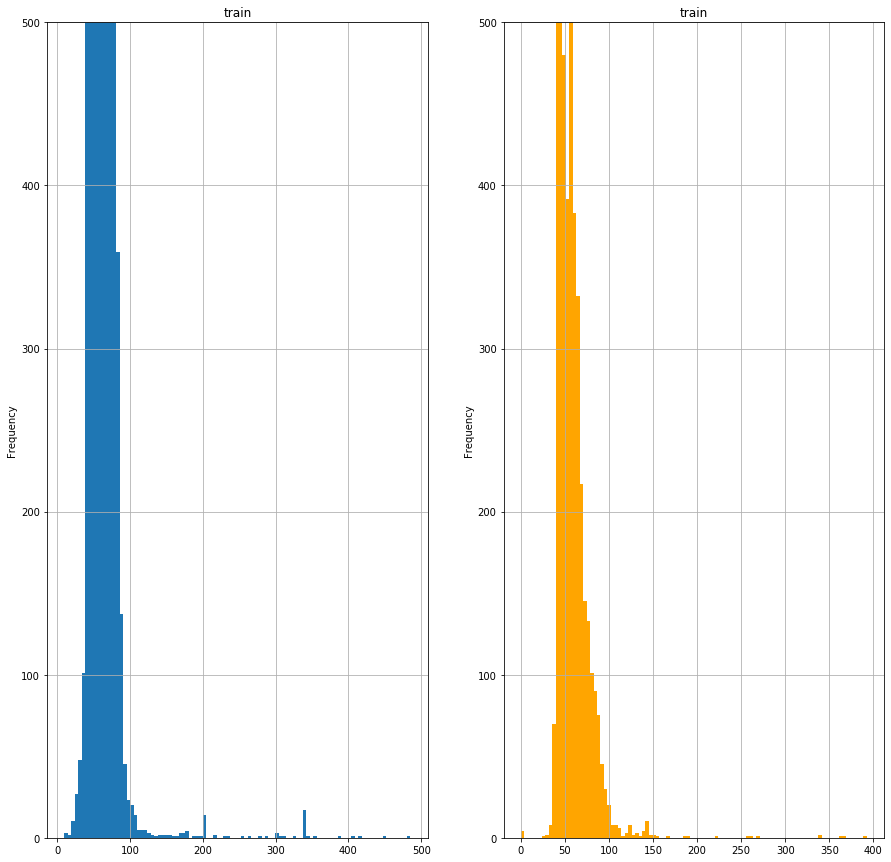

In [36]:
fig, axes = plt.subplots(1, 2)
train['rougher.input.feed_size'].plot(kind='hist', 
                                      figsize=(15, 15), 
                                      ax=axes[0], 
                                      bins=100, 
                                      grid=True, 
                                      title='train',
                                      ylim=(0, 500))
test['rougher.input.feed_size'].plot(kind='hist', 
                                     figsize=(15, 15), 
                                     ax=axes[1], 
                                     bins=100, 
                                     grid=True, 
                                     title='train', 
                                     color='orange',
                                     ylim=(0, 500))

Основная доля размеров гранул находится в диапазоне от 40 до 80. Но есть размеры до 400. На первый взгляд распределение размеров гранул в обучающей и тестовой выборках идентичны. Проверим распределение методом describe()

In [37]:
train['rougher.input.feed_size'].describe()

count    12679.000000
mean        58.414412
std         20.441275
min          9.659576
25%         48.721041
50%         54.651129
75%         63.719220
max        484.967466
Name: rougher.input.feed_size, dtype: float64

In [38]:
test['rougher.input.feed_size'].describe()

count    5229.000000
mean       55.863978
std        18.914656
min         0.046369
25%        43.911874
50%        50.772729
75%        62.265394
max       392.494040
Name: rougher.input.feed_size, dtype: float64

Здесь также не наблюдается различий

### 2.3. Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах

- Для сравнения обучающей и тестовой добавим в тестовую выборку данные с концентратами. Создадим новую выборку test_new

In [39]:
full_conc = full[['date', 'final.output.concentrate_ag', 
                  'final.output.concentrate_pb', 
                  'final.output.concentrate_sol', 
                  'final.output.concentrate_au',
                 'primary_cleaner.output.concentrate_ag',
                  'primary_cleaner.output.concentrate_pb',
                  'primary_cleaner.output.concentrate_sol',
                  'primary_cleaner.output.concentrate_au',
                 'rougher.output.concentrate_ag',
                  'rougher.output.concentrate_pb', 
                  'rougher.output.concentrate_sol',
                  'rougher.output.concentrate_au']]

In [40]:
test_new = test
test_new = test_new.merge(full_conc, on='date', how='left')

- Добавим в обучающую и тестовую выборки столбцы с суммарными концентрациями веществ на 3-х этапах

In [41]:
final_output_conc = ['final.output.concentrate_ag', 
                  'final.output.concentrate_pb', 
                  'final.output.concentrate_sol', 
                  'final.output.concentrate_au']

In [42]:
primary_output_conc = ['primary_cleaner.output.concentrate_ag',
                  'primary_cleaner.output.concentrate_pb',
                  'primary_cleaner.output.concentrate_sol',
                  'primary_cleaner.output.concentrate_au']

In [43]:
rougher_output_conc = ['rougher.output.concentrate_ag',
                  'rougher.output.concentrate_pb', 
                  'rougher.output.concentrate_sol',
                  'rougher.output.concentrate_au']

In [44]:
train['final_output_conc'] = train[final_output_conc].sum(axis=1)
train['primary_output_conc'] = train[primary_output_conc].sum(axis=1)
train['rougher_output_conc'] = train[rougher_output_conc].sum(axis=1)


In [45]:
test_new['final_output_conc'] = test_new[final_output_conc].sum(axis=1)
test_new['primary_output_conc'] = test_new[primary_output_conc].sum(axis=1)
test_new['rougher_output_conc'] = test_new[rougher_output_conc].sum(axis=1)

- Сравним распределения

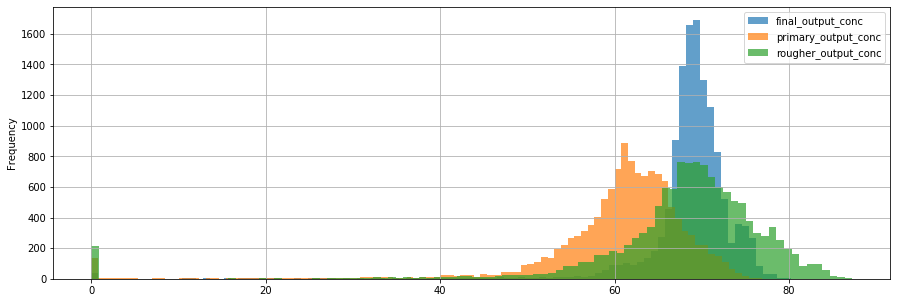

In [46]:
ax = train['final_output_conc'].plot(kind='hist', figsize=(15, 5), bins=100, grid=True, legend=True, alpha=0.7)
train['primary_output_conc'].plot(kind='hist', figsize=(15, 5), ax=ax, bins=100, grid=True, legend=True, alpha=0.7)
train['rougher_output_conc'].plot(kind='hist', figsize=(15, 5), ax=ax, bins=100, grid=True, legend=True, alpha=0.7)
plt.show()

In [47]:
print(train['final_output_conc'].describe()) 
print(train['primary_output_conc'].describe())
print(train['rougher_output_conc'].describe())

count    12679.000000
mean        68.577864
std          6.420817
min          0.000000
25%         67.593534
50%         69.188719
75%         71.050394
max         80.210644
Name: final_output_conc, dtype: float64
count    12679.000000
mean        60.262440
std          9.880960
min          0.000000
25%         58.113840
50%         61.770054
75%         65.283791
max         76.918076
Name: primary_output_conc, dtype: float64
count    12679.000000
mean        67.582614
std         11.888300
min          0.000000
25%         65.155435
50%         69.259055
75%         73.486943
max         87.273435
Name: rougher_output_conc, dtype: float64


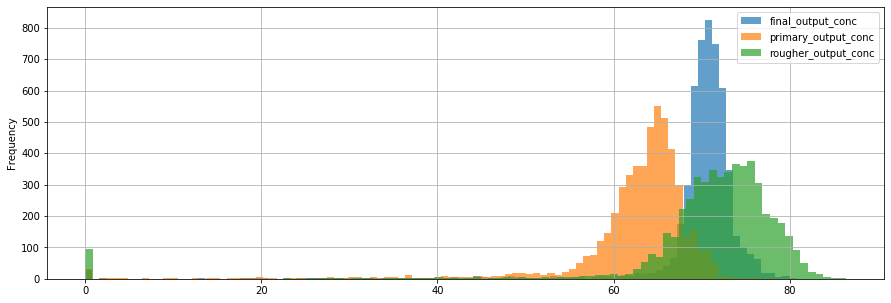

In [48]:
ax = test_new['final_output_conc'].plot(kind='hist', figsize=(15, 5), bins=100, grid=True, legend=True, alpha=0.7)
test_new['primary_output_conc'].plot(kind='hist', figsize=(15, 5), ax=ax, bins=100, grid=True, legend=True, alpha=0.7)
test_new['rougher_output_conc'].plot(kind='hist', figsize=(15, 5), ax=ax, bins=100, grid=True, legend=True, alpha=0.7)
plt.show()

In [49]:
print(test_new['final_output_conc'].describe()) 
print(test_new['primary_output_conc'].describe())
print(test_new['rougher_output_conc'].describe())

count    5229.000000
mean       69.615526
std         7.473195
min         0.000000
25%        69.363400
50%        70.709281
75%        72.084634
max        79.977670
Name: final_output_conc, dtype: float64
count    5229.000000
mean       62.340702
std         8.510653
min         0.000000
25%        61.225854
50%        64.145931
75%        66.123232
max        80.749343
Name: primary_output_conc, dtype: float64
count    5229.000000
mean       70.827765
std        11.419470
min         0.000000
25%        69.230682
50%        72.667060
75%        75.801135
max        86.393020
Name: rougher_output_conc, dtype: float64


В суммарных концентрациях наблюдаются выбросы - от 40 и до 0. Удалим данные выбросы из обучающей выборке, чтобы они не влияли на модель

In [50]:
train = train[(train['final_output_conc'] != 0) & (train['final.output.recovery'] != 0)]

In [51]:
train.shape

(12643, 91)

## Вывод:
1. Распределения в тестовой и обучающих выборках аналогичны, различий не наблюдается.
2. В распределениях наблюдаются аномалии(выбросы) 
3. Данные выбросы удалены из обучающей выборки


# 3. Построение моделей

### 3.1. Напишем функцию для вычисления sMAPE. Сделаем ее метрикой для дальнейших операций

In [52]:
def smape(target, pred):
    x = (abs(target - pred) / ((abs(target) + abs(pred)) / 2)) * 100
    smape = x.sum() / len(target)
    return smape
    

In [53]:
my_scorer = make_scorer(smape)

### 3.2. Обучим разные модели и оценим их качество кросс-валидацией

3.2.1 Посмотрим на корреляцию признаков по отношению к целевым

In [54]:
corr = train[test.columns].corr()
corr

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,final.output.recovery,rougher.output.recovery
primary_cleaner.input.sulfate,1.000000,0.419215,0.116000,0.210617,0.064572,-0.062365,0.077407,-0.056037,0.080308,-0.051234,...,0.183535,-0.034971,0.065506,-0.016453,0.076318,-0.003665,-0.062265,-0.157876,0.399741,0.304197
primary_cleaner.input.depressant,0.419215,1.000000,0.141392,0.271772,-0.121580,0.102337,-0.090787,0.120310,-0.102834,0.124164,...,-0.114314,-0.273682,-0.245509,-0.163676,-0.201854,-0.154124,-0.159950,-0.127655,0.144982,0.025652
primary_cleaner.input.feed_size,0.116000,0.141392,1.000000,-0.028851,-0.109961,0.068071,-0.112652,0.070284,-0.129807,0.068863,...,-0.220897,0.054370,-0.208005,0.153177,-0.178201,0.155168,0.187983,0.067740,0.040477,-0.010591
primary_cleaner.input.xanthate,0.210617,0.271772,-0.028851,1.000000,0.066277,0.021599,0.085254,0.018459,0.058347,0.015395,...,0.030759,-0.314836,-0.044373,-0.205775,-0.064958,-0.200447,-0.204229,-0.086638,0.189955,0.103295
primary_cleaner.state.floatbank8_a_air,0.064572,-0.121580,-0.109961,0.066277,1.000000,0.168028,0.945555,0.178727,0.932321,0.175949,...,0.512701,0.219003,0.554075,0.255659,0.495113,0.247407,0.303456,0.053628,0.183474,0.096616
primary_cleaner.state.floatbank8_a_level,-0.062365,0.102337,0.068071,0.021599,0.168028,1.000000,0.122500,0.977853,0.156841,0.964250,...,0.112303,-0.043795,0.017703,0.108630,0.082875,0.082189,0.182385,0.196568,0.066636,0.049533
primary_cleaner.state.floatbank8_b_air,0.077407,-0.090787,-0.112652,0.085254,0.945555,0.122500,1.000000,0.149161,0.943508,0.147364,...,0.512121,0.200492,0.558305,0.260066,0.484098,0.251952,0.302197,0.032760,0.194162,0.107642
primary_cleaner.state.floatbank8_b_level,-0.056037,0.120310,0.070284,0.018459,0.178727,0.977853,0.149161,1.000000,0.168210,0.969770,...,0.097478,-0.033107,-0.002809,0.123209,0.059332,0.095421,0.177334,0.202164,0.059466,0.046994
primary_cleaner.state.floatbank8_c_air,0.080308,-0.102834,-0.129807,0.058347,0.932321,0.156841,0.943508,0.168210,1.000000,0.167642,...,0.578804,0.205733,0.593364,0.222692,0.547838,0.224457,0.273108,0.042800,0.190370,0.123212
primary_cleaner.state.floatbank8_c_level,-0.051234,0.124164,0.068863,0.015395,0.175949,0.964250,0.147364,0.969770,0.167642,1.000000,...,0.097624,-0.038589,-0.003698,0.116624,0.056666,0.089819,0.172507,0.196406,0.062179,0.049615


In [55]:
corr['final.output.recovery'].describe()

count    54.000000
mean      0.101413
std       0.198481
min      -0.195596
25%      -0.035499
50%       0.064890
75%       0.208428
max       1.000000
Name: final.output.recovery, dtype: float64

Для обучения моделей, используем те признаки, корреляция которых к целевым > 0.1

3.2.2 Разделим признаки в выборках на целевые и необходимые для обучения

In [56]:
X_col_rougher_cor = corr[corr['rougher.output.recovery'] > 0.1].drop(['rougher.output.recovery', 'final.output.recovery'])
X_col_rougher_cor.index

Index(['primary_cleaner.input.sulfate', 'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_c_air', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level',
       'secondary_cleaner.state.floatbank2_a_air',
       'secondary_cleaner.state.floatbank2_b_air',
       'secondary_cleaner.state.floatbank3_a_air',
       'secondary_cleaner.state.floatbank4_a_air',
       'secondary_cleaner.state.floatbank4_b_air',
       'secondary_cleaner.state.floatbank5_a_air',
       'secondary_cleaner.state.floatbank5_b_air'],
      dtype='object')

Для предсказаний эффективности после флотации используем признаки, участвующие в данной процедуре

In [57]:
X_col_rougher = X_col_rougher_cor.index[4:12]
X_col_rougher

Index(['rougher.input.feed_ag', 'rougher.input.feed_pb',
       'rougher.input.feed_sol', 'rougher.input.feed_au',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level'],
      dtype='object')

In [58]:
X_col_final = corr[corr['final.output.recovery'] > 0.1].drop(['rougher.output.recovery', 'final.output.recovery']).index
X_col_final

Index(['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_c_air', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_sol', 'rougher.input.feed_au',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level',
       'secondary_cleaner.state.floatbank2_a_air',
       'secondary_cleaner.state.floatbank2_b_air',
       'secondary_cleaner.state.floatbank3_a_air',
       'secondary_cleaner.state.floatbank4_a_air',
       'secondary_cleaner.state.floatbank4_b_air',
       'secondary_cleaner.state.floatbank5_a_air',
       'secondary_cleaner.state.floatbank5_b_air'],
      dtype='object')

In [59]:
def X_y(data):
    X_rougher = data[X_col_rougher]
    y_rougher = data['rougher.output.recovery']
    X_final = data[X_col_final]
    y_final = data['final.output.recovery']
    return X_rougher, y_rougher, X_final, y_final

In [60]:
X_train_rougher, y_train_rougher, X_train_final, y_train_final = X_y(train)
X_test_rougher, y_test_rougher, X_test_final, y_test_final = X_y(test)

3.2.2 Для обучения выберем модели LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GradientBoostingRegressor

In [61]:
model_linear = LinearRegression()
model_tree = DecisionTreeRegressor(random_state=42)
model_forest = RandomForestRegressor(random_state=42)
model_boost = GradientBoostingRegressor(random_state=42)


In [62]:
def score(model):
    score_rougher = cross_val_score(model, X_train_rougher, y_train_rougher, cv=5, scoring=my_scorer).mean()
    score_final = cross_val_score(model, X_train_final, y_train_final, cv=5, scoring=my_scorer).mean()
    print('smape чернового концентрата:', score_rougher)
    print('smape финального концентрата:', score_final)
    print('итоговый smape:', ((0.25 * score_rougher) + (0.75 * score_final)))

In [63]:
score(model_linear)

smape чернового концентрата: 10.170118497279862
smape финального концентрата: 9.496202342224743
итоговый smape: 9.664681380988522


In [64]:
score(model_tree)

smape чернового концентрата: 13.506174839257502
smape финального концентрата: 16.06225283966981
итоговый smape: 15.423233339566734


In [65]:
score(model_forest)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

smape чернового концентрата: 11.328879298641983
smape финального концентрата: 11.301195857885798
итоговый smape: 11.308116718074842


In [66]:
score(model_boost)

smape чернового концентрата: 9.692709555624386
smape финального концентрата: 9.667531135398132
итоговый smape: 9.673825740454696


Продолжим с моделью GradientBoostingRegressor

Улучшим модель с помощью подбора гиперпараметров

Чтобы использовать GridSearchCV необходимо изменить параметры метрики my_scorer

In [67]:
my_scorer_1 = make_scorer(smape, greater_is_better=False)

In [89]:
param_grid = {
    'n_estimators': [i for i in range(50, 150, 10)],
    'max_depth': [i for i in range(2,5)]
}
search = GridSearchCV(model_boost, param_grid, cv=3, scoring=my_scorer_1)
search.fit(X_train_final, y_train_final)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
                

In [90]:
search.best_params_

{'max_depth': 2, 'n_estimators': 50}

In [91]:
search.best_score_

-9.47804903529843

3.2.3 Проверим модель на тестовой выборке с подобранными гиперпараметрами

In [92]:
def predict(X_test_r, X_test_f):
    model_boost_rougher = GradientBoostingRegressor(random_state=42, n_estimators=50, max_depth=2)
    model_boost_final = GradientBoostingRegressor(random_state=42, n_estimators=50, max_depth=2)
    model_boost_rougher.fit(X_train_rougher, y_train_rougher)
    model_boost_final.fit(X_train_final, y_train_final)
    pred_rougher = model_boost_rougher.predict(X_test_r)
    pred_final = model_boost_final.predict(X_test_f)
    return pred_rougher, pred_final

In [93]:
pred_rougher, pred_final = predict(X_test_rougher, X_test_final)

In [94]:
print('smape чернового концентрата:', smape(y_test_rougher, pred_rougher))
print('smape финального концентрата:', smape(y_test_final, pred_final))
print('итоговый smape:', ((0.25 * smape(y_test_rougher, pred_rougher)) + 0.75 * smape(y_test_final, pred_final)))

smape чернового концентрата: 7.882775432655391
smape финального концентрата: 8.364135089926316
итоговый smape: 8.243795175608586


3.2.4 Создадим константную модель для оценки адекватности моделей

In [95]:
pred_rougher_cons = pd.Series(y_train_rougher.mean(), index=y_test_rougher.index)
pred_final_cons = pd.Series(y_train_final.mean(), index=y_test_final.index)

In [96]:
print('smape чернового концентрата:', smape(y_test_rougher, pred_rougher_cons))
print('smape финального концентрата:', smape(y_test_final, pred_final_cons))
print('итоговый smape:', ((0.25 * smape(y_test_rougher, pred_rougher_cons) + 0.75 * smape(y_test_final, pred_final_cons))))

smape чернового концентрата: 9.974748935440875
smape финального концентрата: 9.552398344041567
итоговый smape: 9.657985991891394


#### Вывод
1. Выполнили предобработку данных. Подготовили их к дальнейшей работе
2. Провели исследовательский анализ данных
3. Обучили модели
4. Лучшей моделью оказалась GradientBoostingRegressor с результатом 8.24%
5. Сравнили модель с константной. Результат константной модели 9,65% против 8.24%.